In [3]:
import random
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Loading the merged train and test dataset

train_data = pd.read_pickle('merged_train.pkl')
test_data = pd.read_pickle('merged_test.pkl')

In [5]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590540, 434) 


 Test Data Shape : (506691, 433) 

*********************************************


## Utility Functions
<br>

In [6]:
def cat_num_features(df):
    
    '''
        Utility Function to get the names of Categorical Features and 
        Numerical Features of the given Dataset.
    '''
    
    catf = []
    numf = []
    
    # Given Categorical Features 
    catf = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', \
            'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', \
            'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', \
            'DeviceType', 'DeviceInfo']
    catf+=['id_'+str(i) for i in range(12,39)]


    # Updating the Categorical Feature Names List based on the columns present in the dataframe
    catf = [feature for feature in catf if feature in df.columns.values]
    numf = [feature for feature in df.columns if feature not in catf and not feature == 'isFraud']
    
    return (catf, numf)  

In [7]:
def label_encode(X_train, X_test, catf):
  
  '''
    Utility Function to Encode Categorical Features.
  '''

  for f in catf:
    
    X_train[f] = X_train[f].astype(str)
    X_test[f] = X_test[f].astype(str)
    
    le = LabelEncoder()
    le.fit(X_train[f])
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    X_train[f] = le.transform(X_train[f])
    
    # Manually Encoding the CV and Test Dataset so as to avoid error for any category which is not present in train set
    
    # All the categories which are not present in train datset are encoded as -1    
    X_test[f] = [-1 if mapping.get(v, -1)==-1 else mapping[v] for v in X_test[f].values ]

  return (X_train, X_test)

In [15]:
def hyperparam_vs_auc(train_roc_auc, cv_roc_auc):
    
    '''
        Utility Function to plot the Training and Cross Validation ROC-AUC Values
        for different Hyperparameter.
    '''
    
    plt.plot(range(len(train_roc_auc)), train_roc_auc, label='Train AUC')
    plt.plot(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC')

    plt.scatter(range(len(train_roc_auc)), train_roc_auc, label='Train AUC points')
    plt.scatter(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC points')
    
    plt.xticks(range(len(train_roc_auc)))
    plt.legend()
    plt.xlabel("Hyperparameter Index")
    plt.ylabel("AUC")
    plt.title("\n Hyperparameter vs ROC-AUC \n")
    plt.grid()
    plt.show()

## Data Preparation
<br>

### Splitting the Dataset
<br>

In [8]:
X_train = train_data.drop(['isFraud', 'TransactionID'], axis=1)
y_train = train_data['isFraud']

X_test = test_data.drop(['TransactionID'], axis=1)

del train_data, test_data

In [9]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Test Data Shape : {} \n".format(X_test.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590540, 432) 


 Test Data Shape : (506691, 432) 

*********************************************


In [10]:
# Storing Categorical and Numerical Feature Names 

catf, numf = cat_num_features(X_train)

#### Label Encoding Categorical Features
<br>

In [11]:
# Imputing the missing values of Categorical Columns with "missing"

X_train[catf] = X_train[catf].fillna('missing')
X_test[catf] = X_test[catf].fillna('missing')


# Label Encoding Categorical Features

X_train, X_test = label_encode(X_train, X_test, catf)

<br>

## Hyperparameter Tuning

<br>

In [12]:
# Hyperparameters

learning_rate = [2e-2, 3e-1, 1e-1]
max_depth = [8, 12, 16]
subsample = [0.6,0.8,1]
colsample_bytree = [0.6,0.8,1]

In [13]:
results = {}

dtrain = xgb.DMatrix(X_train, label=y_train)

for rate in learning_rate:
  for depth in max_depth:
    for sample in subsample:
      for colsample in colsample_bytree:

        params = {
          'objective' : 'binary:logistic',
          'eval_metric' : 'auc',
          'learning_rate' : rate,
          'max_depth' : depth,
          'subsample' : sample,
          'colsample_bytree' : colsample,
          'tree_method' : 'gpu_hist',
          'random_state' : 3,
        }

        history = xgb.cv(
            params,
            dtrain,
            num_boost_round = 3000,
            nfold = 3,
            metrics ='auc',
            early_stopping_rounds = 100,
            verbose_eval=100,
            seed=3,
            shuffle = False
        )

        name = "learning_rate : "+str(rate)+" max_depth : "+str(depth)+" subsample : "+str(sample)+" colsample_bytree : "+str(colsample)
        results[name] = (history.iloc[-1]['train-auc-mean'],history.iloc[-1]['test-auc-mean'])

[0]	train-auc:0.81008+0.00278263	test-auc:0.795041+0.00521012
[100]	train-auc:0.891054+0.00261622	test-auc:0.866463+0.00782797
[200]	train-auc:0.924141+0.00113369	test-auc:0.885427+0.00718767
[300]	train-auc:0.945226+0.000177355	test-auc:0.896236+0.00711035
[400]	train-auc:0.956586+0.000209191	test-auc:0.903733+0.00661229
[500]	train-auc:0.963377+0.000587974	test-auc:0.907885+0.00622295
[600]	train-auc:0.968532+0.000665053	test-auc:0.910266+0.00635438
[700]	train-auc:0.972732+0.000674151	test-auc:0.91177+0.00623318
[800]	train-auc:0.976085+0.000717801	test-auc:0.912756+0.00638385
[900]	train-auc:0.979038+0.000739271	test-auc:0.913356+0.00644674
[1000]	train-auc:0.981554+0.000615811	test-auc:0.913694+0.00617126
[1100]	train-auc:0.983719+0.000708424	test-auc:0.914157+0.00632882
[1200]	train-auc:0.985574+0.000600783	test-auc:0.914517+0.00650925
[0]	train-auc:0.820871+0.0104295	test-auc:0.804801+0.0171881
[100]	train-auc:0.890757+0.00377407	test-auc:0.865395+0.00673999
[200]	train-auc:0.92

In [26]:
train_roc_auc = [auc[0] for auc in results.values()]
cv_roc_auc = [auc[1] for auc in results.values()]

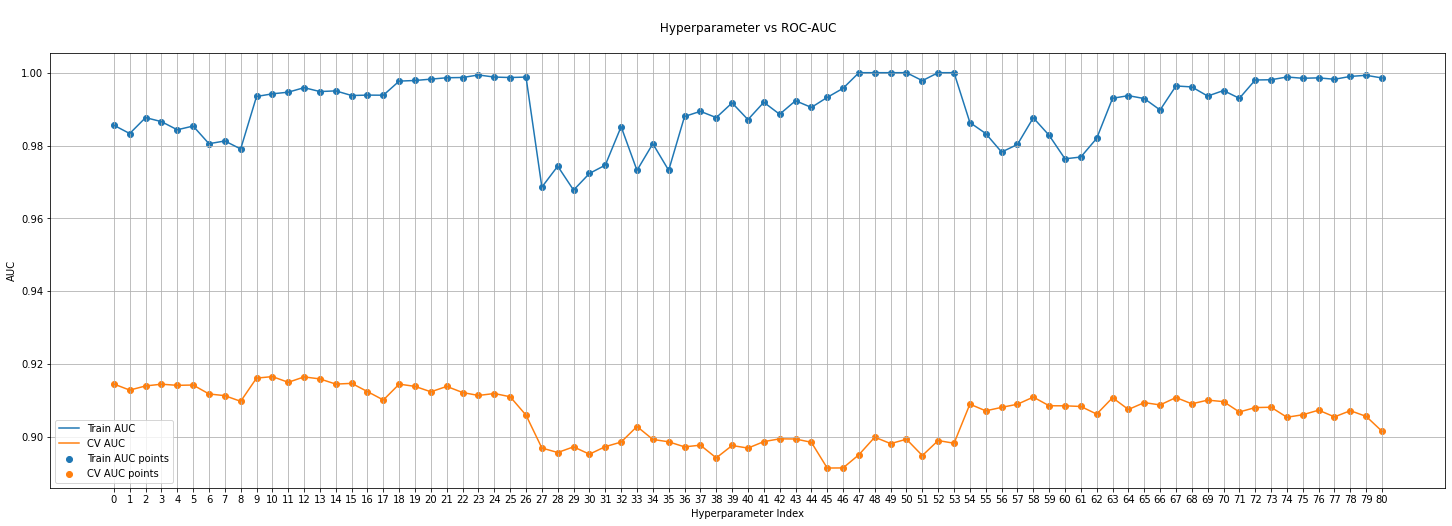

In [35]:
plt.figure(figsize=(25,8))
hyperparam_vs_auc(train_roc_auc, cv_roc_auc)

From the above plot, the best hyperaparameter index is 12.
<br><br>

In [32]:
best_params = list(results.keys())[12]

In [33]:
print("The Best Paramaters are {} ".format(best_params))

The Best Paramaters are learning_rate : 0.02 max_depth : 12 subsample : 0.8 colsample_bytree : 0.6 
